In [1]:
import os
import sys
from PIL import Image
import numpy as np
def normalize(x):
    """
    Normalize a list of sample image data in the range of 0 to 1
    : x: List of image data.  The image shape is (32, 32, 3)
    : return: Numpy array of normalize data
    """
    # TODO: Implement Function
    x=x/255.0
    
    #print (x.shape)
    return x
def array_image(name):
    directory = os.listdir(os.getcwd()+'\\data\\'+name)
    dic = {}
    images = []
    labels = []
    for i in directory:
        dic[i] = os.listdir(os.getcwd()+ '\\data\\'+name+'\\'+i)
    for i,j in dic.items():
        for image in j:
            pic = Image.open(os.getcwd()+'\\data\\'+name+'\\'+i+'\\'+image)
            images.append(list(pic.getdata()))
            labels.append([float(label == i) for label in dic])
  
    images = np.asarray(images)
    labels = np.asarray(labels)     
    return images, labels


In [2]:
images_train,labels_train = array_image('train')
images_test,labels_test = array_image('validation')
images_train = normalize(images_train)
images_test = normalize(images_test)


In [3]:
def next_batch(x,y,batch_size,i):
    """Return the next `batch_size` examples from this data set."""
    num = len(y[:,])
    if i==0:
        perm = np.arange(num)
        np.random.shuffle(perm)
        images = x[perm]
        labels = y[perm]
        k =0
    start = batch_size*i-k*num
    if  start+batch_size > num:
        perm = np.arange(num)
        np.random.shuffle(perm)
        images = x[perm]
        labels = y[perm]
        start = 0
        k = k+1
    end = start+batch_size
    return images[start:end], labels[start:end]

In [30]:
import tensorflow as tf
import numpy
x = tf.placeholder(tf.float32, [None, 2025])
W = tf.Variable(tf.zeros([2025,30]))
b = tf.Variable(tf.zeros([30]))
y = tf.nn.softmax(tf.matmul(x, W) + b)
y_ = tf.placeholder(tf.float32, [None, 30])
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()
perm = np.arange(80350)
np.random.shuffle(perm)
images = images_train[perm]
labels = labels_train[perm]
for i in range(800):
    batchx = images[100*i:100+100*i]
    batchy = labels[100*i:100+100*i]
    sess.run(train_step, feed_dict={x: batchx, y_: batchy})
    

In [4]:
import tensorflow as tf
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

sess = tf.InteractiveSession()
x = tf.placeholder(tf.float32, shape=[None, 2025])
y_ = tf.placeholder(tf.float32, shape=[None, 30])
W = tf.Variable(tf.zeros([2025,30]))
b = tf.Variable(tf.zeros([30]))
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])
x_image = tf.reshape(x, [-1,45,45,1])
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)
W_fc1 = weight_variable([12 * 12 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 12*12*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
W_fc1 = weight_variable([12 * 12 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 12*12*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
sess.run(tf.global_variables_initializer())
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
W_fc2 = weight_variable([1024, 30])
b_fc2 = bias_variable([30])
y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2


cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
sess.run(tf.global_variables_initializer())

perm = np.arange(80350)
np.random.shuffle(perm)
images = images_train[perm]
labels = labels_train[perm]

for i in range(800):
    batchx = images[100*i:100+100*i]
    batchy = labels[100*i:100+100*i]
    if i%50 == 0:
        train_accuracy = accuracy.eval(feed_dict={
            x:batchx, y_: batchy, keep_prob: 1.0})
        print("step %d, training accuracy %g"%(i, train_accuracy))
    sess.run(train_step, feed_dict={x: batchx, y_: batchy, keep_prob: 0.5})

step 0, training accuracy 0.03
step 50, training accuracy 0.21
step 100, training accuracy 0.41
step 150, training accuracy 0.48
step 200, training accuracy 0.67
step 250, training accuracy 0.66
step 300, training accuracy 0.63
step 350, training accuracy 0.74
step 400, training accuracy 0.75
step 450, training accuracy 0.75
step 500, training accuracy 0.81
step 550, training accuracy 0.81
step 600, training accuracy 0.73
step 650, training accuracy 0.74
step 700, training accuracy 0.8
step 750, training accuracy 0.84


In [13]:
saver = tf.train.Saver()
saver.save(sess,os.getcwd())

'd:\\Documents\\mathematicalhandwrriten'

In [10]:
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
sess.run(tf.global_variables_initializer())
perm = np.arange(53577)
np.random.shuffle(perm)
images_test = images_test[perm]
labels_test = labels_test[perm]
acc = []
for i in range(50):    
        acc.append(accuracy.eval(feed_dict={
                   x: images_test[i*1000:i*1000+1000], y_: labels_test[i*1000:i*1000+1000], keep_prob: 1.0}))

In [5]:
from sklearn.metrics import f1_score,recall_score,precision_score

perm = np.arange(53577)
np.random.shuffle(perm)
images_test = images_test[perm]
labels_test = labels_test[perm]
recall = []
precision = []
f1_score = []
for i in range(10):    
    #print("test accuracy %g"%accuracy.eval(feed_dict={
          #x: images_test[i*1000:i*1000+1000], y_: labels_test[i*1000:i*1000+1000], keep_prob: 1.0}))
    y_p = tf.argmax(y_conv, 1)
    val_accuracy, y_pred = sess.run([accuracy, y_p], feed_dict={x:images_test[i*1000:i*1000+1000],
                                                                y_:labels_test[i*1000:i*1000+1000], keep_prob: 1.0})
    
    #print(y_pred) 
    y_true = np.argmax(labels_test[i*1000:i*1000+1000],1)
    #print (y_true)
    precision.append(precision_score(y_true, y_pred,average='micro'))
    recall.append(recall_score(y_true, y_pred,average='micro'))
    f1_score.append(2 * (precision[i] * recall[i]) / (precision[i] + recall[i]))


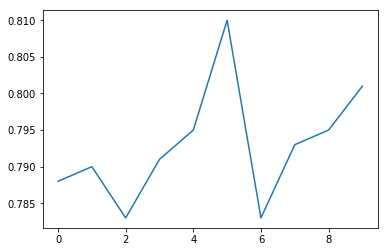

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(f1_score)
plt.savefig('f1_score',label = 'f1_score')